## Notebook 2 of 2

# Taking an Aerial Image and finding a path through its obstacles

In [1]:
import time
import random
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import os
import itertools
from scipy.spatial import cKDTree
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
height = 480
width = 640
n_class = 23

In [4]:
class MyMeanIOU(MeanIoU):
    def update_state(self, y_true, y_pred, sample_weight=None):
        return super().update_state(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1), sample_weight)

In [5]:
loaded_model = load_model("/home/anish/Documents/MLProjects/AerialPhotoPathfinding/unet_model", custom_objects = {"MyMeanIOU" : MyMeanIOU(num_classes = 23)})

## The Probabilistic Road Map Planner
The basic idea behind Probabilistic Road Map is to take random samples from the configuration space of the robot, testing them for whether they are in the free space, and use a local planner to attempt to connect these configurations to other nearby configurations. The starting and goal configurations are added in, and a graph search algorithm is applied to the resulting graph to determine a path between the starting and goal configurations.

The probabilistic roadmap planner consists of two phases: a construction and a query phase. In the construction phase, a roadmap (graph) is built, approximating the motions that can be made in the environment. First, a random configuration is created. Then, it is connected to some neighbors, typically either the k nearest neighbors or all neighbors less than some predetermined distance. Configurations and connections are added to the graph until the roadmap is dense enough. In the query phase, the start and goal configurations are connected to the graph, and the path is obtained by a Dijkstra's shortest path query.

The used PRM Planner has been modified and borrowed from https://github.com/AtsushiSakai/PythonRobotics/blob/master/PathPlanning/ProbabilisticRoadMap/probabilistic_road_map.py .
The code takes in a list of point obstacles and the start and end co-ordinates and returns the path as planned by the PRM planner.

In [6]:
"""
Probabilistic Road Map (PRM) Planner
author: Atsushi Sakai (@Atsushi_twi)
"""

import random
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import itertools

# parameter
N_SAMPLE = 1000  # number of sample_points
N_KNN = 10  # number of edge from one sampled point
MAX_EDGE_LEN = 30.0  # [m] Maximum edge length

show_animation = True


class Node:
    """
    Node class for dijkstra search
    """

    def __init__(self, x, y, cost, parent_index):
        self.x = x
        self.y = y
        self.cost = cost
        self.parent_index = parent_index

    def __str__(self):
        return str(self.x) + "," + str(self.y) + "," +\
               str(self.cost) + "," + str(self.parent_index)


def prm_planning(sx, sy, gx, gy, ox, oy, rr):

    obstacle_kd_tree = cKDTree(np.vstack((ox, oy)).T)

    sample_x, sample_y = sample_points(sx, sy, gx, gy,
                                       rr, ox, oy, obstacle_kd_tree)
    if show_animation:
        plt.plot(sample_x, sample_y, ".b")

    road_map = generate_road_map(sample_x, sample_y, rr, obstacle_kd_tree)

    rx, ry = dijkstra_planning(
        sx, sy, gx, gy, road_map, sample_x, sample_y)

    return rx, ry


def is_collision(sx, sy, gx, gy, rr, obstacle_kd_tree):
    x = sx
    y = sy
    dx = gx - sx
    dy = gy - sy
    yaw = math.atan2(gy - sy, gx - sx)
    d = math.hypot(dx, dy)

    if d >= MAX_EDGE_LEN:
        return True

    D = rr
    n_step = round(d / D)

    for i in range(n_step):
        dist, _ = obstacle_kd_tree.query([x, y])
        if dist <= rr:
            return True  # collision
        x += D * math.cos(yaw)
        y += D * math.sin(yaw)

    # goal point check
    dist, _ = obstacle_kd_tree.query([gx, gy])
    if dist <= rr:
        return True  # collision

    return False  # OK


def generate_road_map(sample_x, sample_y, rr, obstacle_kd_tree):
    """
    Road map generation
    sample_x: [m] x positions of sampled points
    sample_y: [m] y positions of sampled points
    rr: Robot Radius[m]
    obstacle_kd_tree: KDTree object of obstacles
    """

    road_map = []
    n_sample = len(sample_x)
    sample_kd_tree = cKDTree(np.vstack((sample_x, sample_y)).T)

    for (i, ix, iy) in zip(range(n_sample), sample_x, sample_y):

        dists, indexes = sample_kd_tree.query([ix, iy], k=n_sample)
        edge_id = []

        for ii in range(1, len(indexes)):
            nx = sample_x[indexes[ii]]
            ny = sample_y[indexes[ii]]

            if not is_collision(ix, iy, nx, ny, rr, obstacle_kd_tree):
                edge_id.append(indexes[ii])

            if len(edge_id) >= N_KNN:
                break

        road_map.append(edge_id)

    #  plot_road_map(road_map, sample_x, sample_y)

    return road_map


def dijkstra_planning(sx, sy, gx, gy, road_map, sample_x, sample_y):
    """
    s_x: start x position [m]
    s_y: start y position [m]
    gx: goal x position [m]
    gy: goal y position [m]
    ox: x position list of Obstacles [m]
    oy: y position list of Obstacles [m]
    rr: robot radius [m]
    road_map: ??? [m]
    sample_x: ??? [m]
    sample_y: ??? [m]
    @return: Two lists of path coordinates ([x1, x2, ...], [y1, y2, ...]), empty list when no path was found
    """

    start_node = Node(sx, sy, 0.0, -1)
    goal_node = Node(gx, gy, 0.0, -1)

    open_set, closed_set = dict(), dict()
    open_set[len(road_map) - 2] = start_node

    path_found = True

    while True:
        if not open_set:
            print("Cannot find path")
            path_found = False
            break

        c_id = min(open_set, key=lambda o: open_set[o].cost)
        current = open_set[c_id]

        # show graph
#         if show_animation and len(closed_set.keys()) % 2 == 0:
#             # for stopping simulation with the esc key.
#             plt.gcf().canvas.mpl_connect(
#                 'key_release_event',
#                 lambda event: [exit(0) if event.key == 'escape' else None])
#             plt.plot(current.x, current.y, "xg")
#             plt.pause(0.001)

        if c_id == (len(road_map) - 1):
            print("goal is found!")
            goal_node.parent_index = current.parent_index
            goal_node.cost = current.cost
            break

        # Remove the item from the open set
        del open_set[c_id]
        # Add it to the closed set
        closed_set[c_id] = current

        # expand search grid based on motion model
        for i in range(len(road_map[c_id])):
            n_id = road_map[c_id][i]
            dx = sample_x[n_id] - current.x
            dy = sample_y[n_id] - current.y
            d = math.hypot(dx, dy)
            node = Node(sample_x[n_id], sample_y[n_id],
                        current.cost + d, c_id)

            if n_id in closed_set:
                continue
            # Otherwise if it is already in the open set
            if n_id in open_set:
                if open_set[n_id].cost > node.cost:
                    open_set[n_id].cost = node.cost
                    open_set[n_id].parent_index = c_id
            else:
                open_set[n_id] = node

    if path_found is False:
        return [], []

    # generate final course
    rx, ry = [goal_node.x], [goal_node.y]
    parent_index = goal_node.parent_index
    while parent_index != -1:
        n = closed_set[parent_index]
        rx.append(n.x)
        ry.append(n.y)
        parent_index = n.parent_index

    return rx, ry


def plot_road_map(road_map, sample_x, sample_y):  # pragma: no cover

    for i, _ in enumerate(road_map):
        for ii in range(len(road_map[i])):
            ind = road_map[i][ii]

            plt.plot([sample_x[i], sample_x[ind]],
                     [sample_y[i], sample_y[ind]], "-k")


def sample_points(sx, sy, gx, gy, rr, ox, oy, obstacle_kd_tree):
    max_x = max(ox)
    max_y = max(oy)
    min_x = min(ox)
    min_y = min(oy)

    sample_x, sample_y = [], []

    while len(sample_x) <= N_SAMPLE:
        tx = (random.random() * (max_x - min_x)) + min_x
        ty = (random.random() * (max_y - min_y)) + min_y

        dist, index = obstacle_kd_tree.query([tx, ty])

        if dist >= rr:
            sample_x.append(tx)
            sample_y.append(ty)

    sample_x.append(sx)
    sample_y.append(sy)
    sample_x.append(gx)
    sample_y.append(gy)

    return sample_x, sample_y

A custom function translatePathToWords is created which assumes the starting orientation of the rover to face south relative to the input picture, and dictates the instructions to follow the computed path. The turning angles are computed relative to the rover's orientation, with a +ve angle rotation signifying Left side rotation relative to the rover and -ve angle rotation signifying Right side rotation relative to the rover's orientation.

In [7]:
def translatePathToWords(rx, ry):
    rx_loop = reversed(rx)
    ry_loop = reversed(ry)

    point0_x = 0
    point1_x = next(rx_loop)
    point1_y = next(ry_loop)
    point0_y = point1_y

    for (x_cord, y_cord) in zip(rx_loop, ry_loop):
        point2_x = x_cord
        point2_y = y_cord
        m1 = (point2_y - point1_y)/(point2_x - point1_x)
        m2 = (point0_y - point1_y)/(point0_x - point1_x)
        tanthe = (m1-m2)/(1+m1*m2)
        theta = np.arctan(tanthe)*(180/np.pi)
    
        distance = np.sqrt((point2_x-point1_x)**2 + (point2_y-point1_y)**2)
        print("turn", theta, "degree")
        print("translate", distance, "units")
        print("-------")
        
        point0_x = point1_x
        point0_y = point1_y
    
        point1_x = point2_x
        point1_y = point2_y
        
def find_Path(obs_x, obs_y, sx, sy, gx, gy):
    print(" start!!")

    # start and goal position
#     sx = 25.0  # [m]
#     sy = 100.0  # [m]
#     gx = 150.0  # [m]
#     gy = 225.0  # [m]
    robot_size = 5.0  # [m]

    ox = obs_x
    oy = obs_y

    if show_animation:
        plt.plot(ox, oy, ".k")
        plt.plot(sx, sy, "^r")
        plt.plot(gx, gy, "^c")
        plt.grid(True)
        plt.axis("equal")

    rx, ry = prm_planning(sx, sy, gx, gy, ox, oy, robot_size)

    assert rx, 'Cannot find path'

    if show_animation:
        plt.plot(rx, ry, "-r")
        plt.pause(0.001)
        plt.show()
        
#     plt.imshow(out)
#     plt.plot(ry, rx)
#     plt.plot([sy, gy], [sx, gx], 'bs')
    return rx, ry, sx, sy, gx, gy
    
#     translatePathToWords(rx,ry)

#### The Input image is processed to find out the outlines of obstacles using the Semantic Segmentation Model, and it's coordinates are stored in a list to be fed to the PRM Planner.

In [8]:
def processImageForPath(input_img):
    input_img = input_img.reshape(1, height, width, 3)
    out = loaded_model.predict(input_img/255.)
    out = out.reshape((240, 320, n_class)).argmax(axis = -1)
    fig, axs = plt.subplots(1, 4, figsize=(25, 25), constrained_layout=True)

    input_img = inp_img.reshape((height, width, 3))
    axs[0].imshow(inp_img.astype('uint8'))
    axs[0].set_title('original image-002.jpg from train set')
    axs[0].grid(False)

    axs[1].imshow(out)
    axs[1].set_title('prediction image-out.png')
    axs[1].grid(False)

    out_proc = out.copy()
    indices_non_one = out != 1
    out_proc[indices_non_one] = 0
    

    axs[2].imshow(out_proc)
    axs[2].set_title("After Processing into Binary")
    axs[2].grid(True)
    
    out_proc_edge = out_proc.copy()

    for row in out_proc_edge:
        for i in range(1,303):
            if(row[i-1] == 0 and row[i] == 0 and row[i+1] == 1):
                row[i] = 2
            if(row[i-1] == 1 and row[i] == 0 and row[i+1] == 0):
                row[i] = 2
            
    indices_zero = out_proc_edge == 0
    out_proc_edge[indices_zero] = 1
    
    axs[3].imshow(out_proc_edge)
    axs[3].set_title("After Processing to get Edges")
    axs[3].grid(True)
    
    indices_obs = out_proc_edge == 2
    ind = np.where(out_proc_edge == 2)
    
    no_of_obs = len(ind[1]) #No. of point obstacles
    print(no_of_obs)
    obs_inds = []
    obs_x = []
    obs_y = []
    for i in range(0,no_of_obs) :
        obs_inds.append((ind[0][i], ind[1][i]))
        obs_x.append(ind[0][i])
        obs_y.append(ind[1][i])
    
#     rx, ry, sx, sy, gx, gy = find_Path(obs_x = obs_x, obs_y = obs_y, out = out)
        
    return out, out_proc, out_proc_edge, obs_x, obs_y

## Now finding a path through a given Aerial Image -

1446


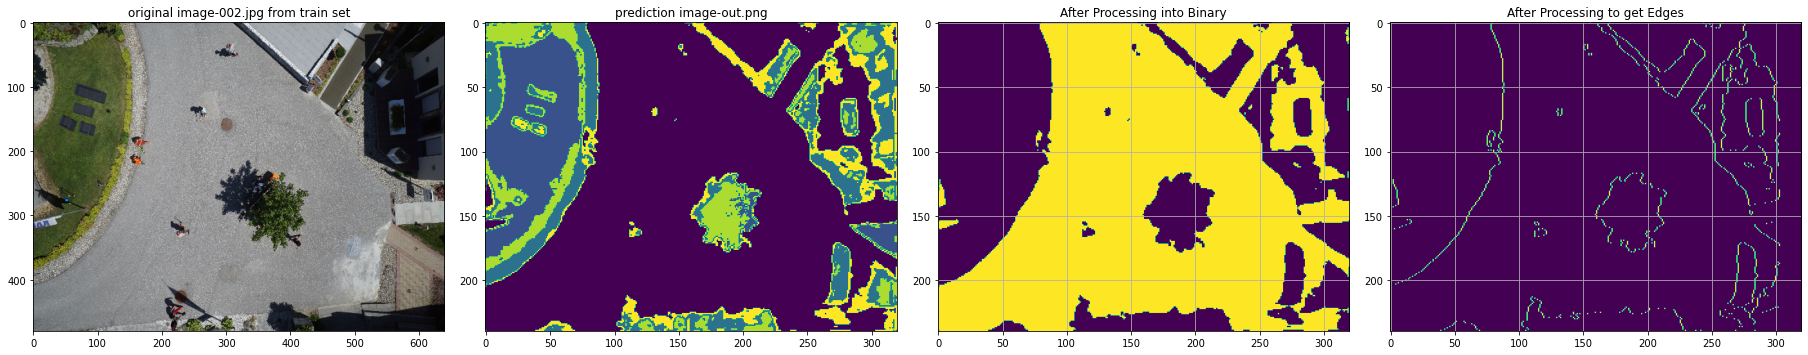

In [9]:
inp_img = img_to_array(load_img("/home/anish/Documents/MLProjects/AerialPhotoPathfinding/semantic_drone_dataset/original_images/train/data/002.jpg", target_size = (height,width)))
out, out_proc, out_proc_edge, obs_x, obs_y = processImageForPath(inp_img)

 start!!
goal is found!


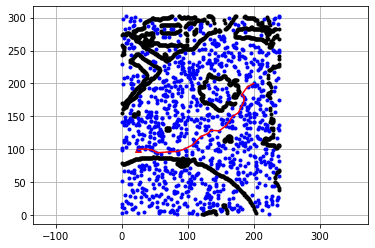

In [10]:
start_x = 25.0
start_y = 100.0
goal_x = 200.0
goal_y = 200.0
rx, ry, sx, sy, gx, gy = find_Path(obs_x = obs_x, 
                                   obs_y = obs_y, 
                                   sx = start_x, 
                                   sy = start_y, 
                                   gx = goal_x, 
                                   gy = goal_y)

## Plotting the path in the Semantic Segmented Image

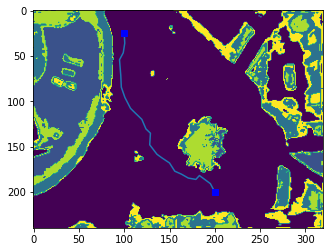

In [11]:
plt.imshow(out)
plt.plot(ry, rx)
plt.plot([sy, gy], [sx, gx], 'bs')

### Translating the Path to a set of instructions

In [12]:
translatePathToWords(rx,ry)

turn 2.964828860145303 degree
translate 10.731284858744864 units
-------
turn -11.864869160460284 degree
translate 10.744527675339766 units
-------
turn -19.285404904236128 degree
translate 8.721168183141426 units
-------
turn 32.76504386401705 degree
translate 17.723699427637815 units
-------
turn -2.0076678429491674 degree
translate 12.611379453328974 units
-------
turn 16.6179351096347 degree
translate 11.959246984732061 units
-------
turn 8.068781076536592 degree
translate 13.508246898670073 units
-------
turn 17.298632007542864 degree
translate 3.69561228823276 units
-------
turn 1.4873135322434587 degree
translate 13.801955049073479 units
-------
turn -22.792962980429294 degree
translate 11.478934832561476 units
-------
turn 23.023824251595496 degree
translate 6.886365241502364 units
-------
turn -49.941306830798865 degree
translate 12.780762132725686 units
-------
turn 41.03994729796277 degree
translate 13.18218967191555 units
-------
turn 16.601255520856817 degree
translate 6.8